#  Generating galaxy images with Variational Autoencoders



We will use the [COSMOS galaxy dataset](https://zenodo.org/record/3242143) observed by a [Hubble Space Telescopy survey](https://cosmos.astro.caltech.edu/page/hst). The full dataset can be downloaded from the COSMOS webpage, however it is 4.4G in size so we have uploaded a reduced version of the dataset to the following [google drive](https://drive.google.com/file/d/1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-/view?usp=share_link). The code used to generate this file from the raw data can be found in the file `preprocess_cosmos_data.py`. As part of the preprocessing, we have removed noisy images. 

The goal of this tutorial is to implement a Variational Auto Encoder (VAE) to generate galaxy images and explore the properties of the learned latent space together with the impact of different hyperparameter choices. The model's implementation shown here is heavily based in [Sid's implementation](https://github.com/smsharma/minified-generative-models/blob/main/01_beta_vae.ipynb).

There will be some questions to check your understanding within the notebook marked with 🤔 

## VAE = Bayesian latent-variable model trained with variational inference

As explained in the lectures, VAEs can be thought as bayesian latent-variable models, that model the data $x$ through latent variables $z$ as $p(x) = \int dz p(z) p_\theta(x|z)$, which are trained with variational inference by minimizing the ELBO:

$\mathrm{ELBO} = \langle \log p_\theta(x|z) \rangle_{q_\phi}  - D_{\mathrm{KL}}(q_\phi(\theta|x) || p(\theta ))$ 

where the first term is referred to as Distortion (measuring the model's ability to reconstruct the data accurately, and therefore the information loss), and the second term is known as Rate (regularizes the model such that the latent space is structured in a particular way that improves the quality of the generated samples, it quantifies the amount of compression)

In the figure below we show an schematic representation of the model taken from the lecture's slides

![My Image](./images/vae.png)



In our example, we will define the likelihood of the data, $ \log p_\theta(x|z)$ as a Gaussian distribution with the mean being the reconstructed data and whose variance, $\sigma$ will be a hyperparameter that we tune. We will show how that as we increase $\sigma$, the reconstructions become worse but the latent space may be better suited for sampling.

### Estimating the KL divergence

Regarding the KL divergence term in the ELBO, most distributions implemented in pyro will have implemented the analytical kl divergence, if it exists, between the two distributions. This is indeed the case for Gaussian distributions, and therefore you only need to call the method  `dist.kl_divergence(q,p)`, for the distribution objects `q` and `p`, to comupte their KL divergence.


🤔 Feel free to play around with `dist.kl_divergence(q,p)` to understand how the KL divergence works. You can define two normal distributions with different means and variances and see how the values of the kl vary  `dist.Normal(loc=mean, scale=variance)`

🤔 if you're feeling adventorous you can write down a function to estimate the KL divergence through Monte Carlo sampling given two arbitrary distributions `q` and `p` 

In [1]:
import jax
import jax.numpy as np
import numpyro.distributions as dist


p = dist.MixtureSameFamily(
    mixing_distribution=dist.Categorical(probs=np.array([0.5, 0.5])),
    component_distribution=dist.Normal(
        loc=np.array([-0.2, 1]), scale=np.array([0.4, 0.5])  # One for each component.
    ),
)
q = dist.Normal(loc=0.0, scale=1.0)


#print(dist.kl_divergence(q, p))


In [2]:
def kl_via_sampling(p, q, n_samples=1000):
    key = jax.random.PRNGKey(1)
    # Get samples from q
    sample_set = q.sample(
        key=key,
        sample_shape=(
            n_samples,
        ),
    )
    # Use the definition of KL-divergence
    return np.mean(q.log_prob(sample_set) - p.log_prob(sample_set))
kl_via_sampling(q, p)

Array(0.19784227, dtype=float32)

## Now let's get started

In [3]:
import jax.numpy as np
import numpy as onp
import jax
from jax import random

from flax import linen as nn
from einops import rearrange
import optax
from tqdm.notebook import tqdm
from tqdm import trange
import numpyro.distributions as dist
from typing import Tuple, Dict
import matplotlib.pyplot as plt


# feel free to comment this line, it was added to lighten the notebook and push it to github
plt.rcParams['figure.dpi'] = 60 

In [4]:
x = np.load('data/cosmos_128.npy')
n_pixels = (x.shape[1], x.shape[2])

In [5]:
x.shape # (n_images, n_pixels_x, n_pixels_y,)

(6210, 128, 128)

In [6]:
# Let's look at some data examples, you should see some clean galaxy images.

from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(6, 6),axes_pad=0.1,)

for ax, im in zip(grid, x[onp.random.randint(len(x), size=36)]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()

In [ ]:
# Let's start by adding the channel dimension (just a dummy) and standarzing the data
x = x[..., None]
x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std

In [ ]:
class MLP(nn.Module):
    """ Simple MLP with gelu activation function.

    Args:
        hidden_dim: dimensionality of the hidden layers
        out_dim: dimensionality of the output layer
        n_layers: number of hidden layers

    """
    hidden_dim: int = 256
    out_dim: int = 2
    n_layers: int = 4

    @nn.compact
    def __call__(self, x: np.array)->np.array:
        """ Applies the MLP to the input.

        Args:
            x (np.array): input data 

        Returns:
            np.array: output data 
        """
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x



🤔 Once the VAE model runs and generates samples, if you are using a GPU, you can play around with convolutional neural networks instead. See the following code for an example of a convolutional network in jax. You will need to adapt the code below to work with the CNN.

In [ ]:
class Encoder(nn.Module):
    dim_hidden : int = 64
    dim_latents : int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.dim_hidden, kernel_size=(3, 3), strides=2)(x) 
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)  # Flatten to single feature vector
        x = nn.Dense(self.dim_latents)(x)
        return x

class Decoder(nn.Module):
    dim_hidden : int = 64

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8 * 8 *self.dim_hidden)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], 8, 8, -1)
        x = nn.ConvTranspose(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        #x = nn.ConvTranspose(features=self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)
        #x = nn.relu(x)
        x = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(1, 1))(x)
        return x

In [ ]:
class VAE(nn.Module):
    """ Implementation of a Variational Autoencoder.

    Args:
        num_latents: dimensionality of the latent space
        num_out: dimensionality of the data 

    """
    num_latents: int = 128 
    num_out: int = 2

    def setup(self):
        """ Initializes the encoder and decoder networks.
        """
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=n_pixels[0]*n_pixels[1])

    def encode(self, x: np.array, key: np.array) -> Tuple[np.array, np.array, np.array]:
        """ Encodes the input data into the latent space.

        Args:
            x (np.array): data to encode
            key (np.array): random key to sample latent variables 

        Returns:
            Tuple[np.array, np.array, np.array]: latent variables, and mean and logvar of the variational distribution
        """
        # Flatten x (won't be necessary if using a CNN encoder)
        x = rearrange(x, 'b h w c -> b (h w c)')
        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]
        z = dist.Normal(loc=mu, scale=np.exp(0.5 * logvar)).sample(key=key)
        return z, mu, logvar

    def decode(self, z: np.array)->np.array:
        """ Decodes the latent variables into the data space.

        Args:
            z (np.array): latent variables 

        Returns:
            np.array: decoded data 
        """
        return self.decoder(z)

    def __call__(self, x: np.array, key: np.array)->Tuple[np.array, np.array, np.array]:
        """ Applies the VAE to the input data.

        Args:
            x (np.array): data to encode 
            key (np.array): random key to sample latent variables 

        Returns:
            Tuple[np.array, np.array, np.array]: decoded data, and mean and logvar of the variational distribution 
        """
        z, mu, logvar = self.encode(x, key)
        recon_x = self.decode(z)
        return recon_x, mu, logvar



Let's now define the VAE's loss function by computing the ELBO defined above

In [ ]:
# Note that we decore the function with `vmap` to make it work with batches of data
@jax.vmap
def rate(mu: float, logvar: float)->float:
    """ KL-divergence between latent variational distribution and unit Normal prior.

    Args:
        mu (float): mean of the variational distribution 
        logvar (float): log-variance of the variational distribution 

    Returns:
        float: KL-divergence 
    """
    prior_latent = dist.Normal(loc=0., scale=1.)  # Prior
    q_latent = dist.Normal(loc=mu, scale=np.exp(0.5 * logvar))  # Variational latent distrib.
    return dist.kl_divergence(q_latent, prior_latent)


def get_distortion(pred: np.array, true: np.array, reconstruction_error: float =1.e-2)->float:
    """ Reconstruction loss, here we assume a Gaussian noise model with some sigma, 
    called reconstruction_error.

    Args:
        pred (np.array): reconstructed data 
        true (np.array): original data 
        reconstruction_error (float, optional): sigma of the noise model. Defaults to 1.e-2.

    Returns:
        float: reconstruction loss 
    """
    true = rearrange(true, 'h w c -> (h w c)')
    log_prob = dist.Normal(loc=pred, scale=reconstruction_error).log_prob(true)
    return -log_prob

def distortion(pred: np.array, true: np.array, reconstruction_error: float)->np.array:
    """ vectorized version of the reconstruction loss.

    Args:
        pred (np.array): batch of reconstructed data 
        true (np.array): batch of original data 
        reconstruction_error (float): sigma of the noise model 

    Returns:
        np.array: reconstruction loss per sample in batch
    """
    return jax.vmap(get_distortion, in_axes=(0, 0, None))(pred, true, reconstruction_error)

from functools import partial

@partial(jax.jit, static_argnums=(1,))
def loss_fn(params: Dict, vae: "nn.Module", x_batch:np.array, reconstruction_error: float, key: np.array)->float:
    """ Loss function for the VAE.

    Args:
        params (Dict): model parameters 
        vae (nn.Module): VAE model 
        x_batch (np.array): batch of data 
        reconstruction_error (float): sigma of the noise model 
        key (np.array): random key used to sample latent variables 

    Returns:
        float: elbo 
    """
    recon_x, mean, logvar = vae.apply(params, x_batch, key)
    R = rate(mean, logvar,).mean(-1)
    D = distortion(recon_x, x_batch, reconstruction_error).mean(-1)
    loss = D + R
    return loss.mean()

In [ ]:
num_latents = 64  # 🤔 feel free to play around with this value and see the effect on 
# the reconstructions and on the generated samples
num_out = n_pixels[0]*n_pixels[1]
reconstruction_error = 1.e-1

# Initialize the vae model
vae = VAE(num_latents=num_latents, num_out=num_out,)

# Initialize the model parameters by doing a forward pass, 
# note that this is how flax figures out the input and output shapes of the different layers
key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = vae.init_with_output(key, x[:16],  z_key)

In [ ]:
# Now let's train the model
n_steps = 1_000 
n_batch = 512 

opt = optax.adam(learning_rate=1e-4)
opt_state = opt.init(params)

loss_values = []
with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batch of data
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        x_batch = x[idx]

        # Get loss and update the parameters
        key, subkey = jax.random.split(key)
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, reconstruction_error, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)
        loss_values.append(loss)

100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s, val=5.5108175]


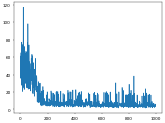

In [ ]:
# Plot the loss curve
plt.plot(loss_values)

## Generating new samples

In [ ]:
@jax.jit
def generate_samples(params: Dict, z: np.array)->np.array:
    """ Generate samples from the VAE.

    Args:
        params (Dict): parameters of the VAE encoder and decoder
        z (np.array): latent variables 

    Returns:
        np.array: generated samples 
    """
    def eval_decoder(vae):
        return vae.decoder(z)
    return nn.apply(eval_decoder, vae)(params)

# Sample from the latent variables from the prior
z = jax.random.normal(key, shape=(16, num_latents))
# generate samples from those latents by calling the decoder
x_samples = generate_samples(params, z)

# Rearrange the dimensions to plot
x_samples = rearrange(x_samples, 'b (h w c) -> b h w c', h=n_pixels[0], w=n_pixels[1], c=1)

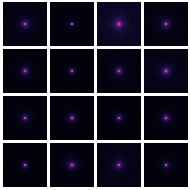

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8., 8.))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),axes_pad=0.1,)

for ax, im in zip(grid, x_samples[..., 0]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()

## How good is the model at reconstructing the original data?

We will know compare the encoded-decoded samples to the original data to assess how well can the model reconstruct the data

In [ ]:

key, subkey = jax.random.split(key)
recon_x, mean, logvar = vae.apply(params, x_batch, key)

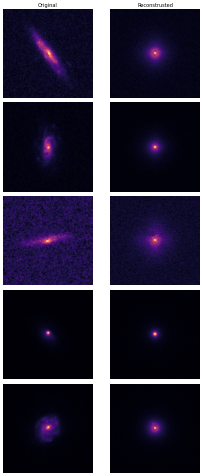

In [ ]:
nrows = 5
fig, ax = plt.subplots(ncols=2,nrows=nrows, figsize=(8,16))
for i in range(nrows):
    ax[i,0].imshow((x_batch[i]* x_std + x_mean), cmap='magma')
    ax[i,1].imshow((recon_x[i]* x_std + x_mean).reshape(n_pixels[0], n_pixels[1]) , cmap='magma')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

ax[0,0].set_title('Original')
ax[0,1].set_title('Reconstrusted')
plt.tight_layout()

## Exploring the structure of the latent space

Now we will focus on exploring the latent space. We will first decompose it in principal components, by using PCAs, and we will look at how the two first components are aranged.

Text(0.5, 1.0, 'Latents, first two PCs')

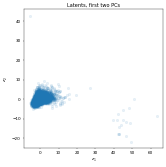

In [ ]:
from sklearn.decomposition import PCA

# Determine the number of galaxy images that we want to plot
n_plot = 20000
def get_encodings(vae: "nn.Module")->np.array:
    """ Get the encodings of a subset of the data

    Args:
        vae (nn.Module): vae model 

    Returns:
        np.array: encodings 
    """
    z, mu, logvar = vae.encode(x[:n_plot], key=key)
    return z

# get the latent variables
z = nn.apply(get_encodings, vae)(params)

# Do a PCA on the latent space and plot the first two PCs
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)
plt.figure(figsize=(6, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1],  alpha=0.1)

plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.title('Latents, first two PCs')

Now we will plot the galaxy images at their latent space locations to look for visual correlations between the galaxies and their position in the latent space

Text(0.5, 1.0, 'Latents, first two PCs')

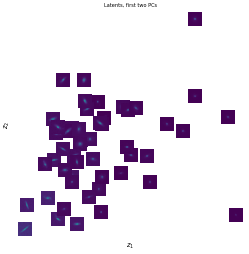

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.ndimage import zoom

# we will need to scale the images down to thumbnail size
def scale_image_to_thumbnail(image, thumbnail_size=(32, 32)):
    """
    Scales an image down to thumbnail size using scipy.

    Args:
        image (numpy.ndarray): Input image of size 128x128.
        thumbnail_size (tuple): Desired thumbnail size, default is 32x32.

    Returns:
        numpy.ndarray: Scaled image.
    """
    scale_factor = thumbnail_size[0] / image.shape[0] # Assuming square image, so only one scale factor needed
    return zoom(image, scale_factor)

n_plot=50
thumbnail_size = (64, 64) # Desired size of the thumbnail image
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the scatter points
ax.scatter(z_pca[:n_plot, 0], z_pca[:n_plot, 1])

# Overlay the images on the scatter plot
for image, (pos_x, pos_y) in zip(x[:n_plot].squeeze(), z_pca[:n_plot]):
    image_resized = scale_image_to_thumbnail(image, thumbnail_size)
    imagebox = OffsetImage(image_resized, zoom=0.5, resample=True, clip_path=None) # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (pos_x, pos_y), frameon=False)
    ax.add_artist(ab)

ax.tick_params(left=False, right=False, bottom=False, top=False, labelleft=False, labelright=False, labelbottom=False, labeltop=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel('$z_1$', fontsize=16)
plt.ylabel('$z_2$', fontsize=16)

plt.title('Latents, first two PCs')

## Finding similar galaxies 

Another interesting property of the latent space, is that it allows us to search for pairs of similar or dissimilar galaxies. We can do this simply by estimating the Euclidian distance in latent space.

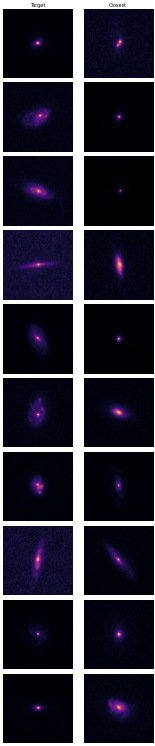

In [ ]:
# show how to find nearest neighbors
def find_closest_image(all_latents, target_index):
    target_latent = all_latents[target_index]
    other_latents = np.delete(all_latents, target_index, axis=0)
    # Compute distances to the other latent variables
    distances = np.linalg.norm(other_latents - target_latent, axis=1)
    closest_index = np.argmin(distances)
    return closest_index



nrows = 10 
fig, ax = plt.subplots(ncols=2,nrows=nrows, figsize=(6,25))
for i, j in enumerate(range(80,80 + nrows)):
    closest_index = find_closest_image(z_pca, j)
    ax[i, 0].imshow(x[j], cmap='magma')
    ax[i, 1].imshow(x[closest_index], cmap='magma')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

ax[0,0].set_title('Target')
ax[0,1].set_title('Closest')
plt.tight_layout()

## Finding rare galaxies

Since the model was trained by minimizing the ELBO, we can estimate the probability of the data $p(x)$ by averaging several calls to the ELBO with different samples from the latent space

In [ ]:
# find high and low probability images
def elbo(vae, n_elbo_evaluations=10,):
    # Sample more than one z to get a better estimate of the expectation
    x_batch = x[:n_plot]
    key = jax.random.PRNGKey(0)
    elbos = []
    for _ in range(n_elbo_evaluations):
        key, subkey = jax.random.split(key)
        z, mu, logvar = vae.encode(x_batch, key)
        recon_x = vae.decode(z)
        R = rate(mu, logvar).mean(-1)
        D = distortion(recon_x, x_batch, reconstruction_error).mean(-1)
        elbos.append(-(D + R)) #TODO: check if this minus sign is correct
    return np.mean(np.array(elbos),axis=0) 

In [ ]:

p_x = nn.apply(elbo, vae, )(params)

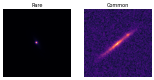

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(x[p_x.argmin()], cmap='magma')
ax[1].imshow(x[p_x.argmax()] , cmap='magma')
ax[0].set_title('Rare')
ax[1].set_title('Common')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

#TODO: add something on careful when using as density estimators and OOD data

## Let's now train a $\beta$-VAE


As explained in the lectures, the $\sigma$ value used in our noise model to define the data likelihood controls the compromise between reconstructing the data well, and capturing the most important information in the latent space. To demonstrate this we could train different VAE models with varying $\sigma$ values. Alternatively, we can add an additional $\sigma$ input to the VAE such that we can train it with different $\sigma$ values. We will do the latter here. In what follows we will refer to $\sigma$ as $\beta$ as well, since both are very closely related

In [ ]:
class BetaVAE(nn.Module):
    """ Implementation of a Variational Autoencoder.

    Args:
        num_latents: dimensionality of the latent space
        num_out: dimensionality of the data 

    """
    num_latents: int = 128 
    num_out: int = 2

    def setup(self):
        """ Initializes the encoder and decoder networks.
        """
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=n_pixels[0]*n_pixels[1])

    def encode(self, x: np.array, beta: np.array, key: np.array) -> Tuple[np.array, np.array, np.array]:
        """ Encodes the input data into the latent space.

        Args:
            x (np.array): data to encode
            beta (np.array): beta parameter that controls the reconstruction error
            key (np.array): random key to sample latent variables 

        Returns:
            Tuple[np.array, np.array, np.array]: latent variables, and mean and logvar of the variational distribution
        """
        # Flatten x (won't be necessary if using a CNN encoder)
        x = rearrange(x, 'b h w c -> b (h w c)')
        x = np.concatenate([x, beta], axis=-1)
        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]
        z = dist.Normal(loc=mu, scale=np.exp(0.5 * logvar)).sample(key=key)
        return z, mu, logvar

    def decode(self, z: np.array, beta: np.array)->np.array:
        """ Decodes the latent variables into the data space.

        Args:
            z (np.array): latent variables 
            beta (np.array): beta parameter that controls the reconstruction error

        Returns:
            np.array: decoded data 
        """
        z = np.concatenate([z, beta], axis=-1)
        return self.decoder(z)

    def __call__(self, x: np.array, beta: np.array, key: np.array)->Tuple[np.array, np.array, np.array]:
        """ Applies the VAE to the input data.

        Args:
            x (np.array): data to encode 
            beta (np.array): beta parameter that controls the reconstruction error
            key (np.array): random key to sample latent variables 

        Returns:
            Tuple[np.array, np.array, np.array]: decoded data, and mean and logvar of the variational distribution 
        """
        z, mu, logvar = self.encode(x, beta, key)
        recon_x = self.decode(z, beta)
        return recon_x, mu, logvar



In [ ]:
# Note that we decore the function with `vmap` to make it work with batches of data
@jax.vmap
def rate(mu: float, logvar: float)->float:
    """ KL-divergence between latent variational distribution and unit Normal prior.

    Args:
        mu (float): mean of the variational distribution 
        logvar (float): log-variance of the variational distribution 

    Returns:
        float: KL-divergence 
    """
    prior_latent = dist.Normal(loc=0., scale=1.)  # Prior
    q_latent = dist.Normal(loc=mu, scale=np.exp(0.5 * logvar))  # Variational latent distrib.
    return dist.kl_divergence(q_latent, prior_latent)


@jax.vmap
def distortion(pred: np.array, true: np.array, beta: float)->float:
    """ Reconstruction loss, here we assume a Gaussian noise model with some sigma, 
    called reconstruction_error.

    Args:
        pred (np.array): reconstructed data 
        true (np.array): original data 
        beta (float): beta parameter that controls the reconstruction error

    Returns:
        float: reconstruction loss 
    """
    true = rearrange(true, 'h w c -> (h w c)')
    log_prob = dist.Normal(loc=pred, scale=beta).log_prob(true)
    return -log_prob



from functools import partial

@partial(jax.jit, static_argnums=(1,))
def loss_fn(params: Dict, beta_vae: "nn.Module", x_batch:np.array, log_beta_batch: np.array, key: np.array)->float:
    """ Loss function for the BetaVAE.

    Args:
        params (Dict): model parameters 
        vae (nn.Module): BetaVAE model 
        x_batch (np.array): batch of data 
        log_beta_batch (np.array): batch of log beta parameters
        key (np.array): random key used to sample latent variables 

    Returns:
        float: elbo 
    """
    beta_batch = np.power(10., log_beta_batch)
    recon_x, mean, logvar = beta_vae.apply(params, x_batch, beta_batch, key)
    R = rate(mean, logvar,).mean(-1)
    D = distortion(recon_x, x_batch, beta_batch).mean(-1)
    loss = D + R
    return loss.mean()

In [ ]:
beta_vae = BetaVAE(num_latents=num_latents, num_out=num_out,)

#let's initialize the parameters 
key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = beta_vae.init_with_output(key, x[:16], np.ones((16, 1)), z_key)


In [ ]:
print(loss_fn(params, beta_vae, x[:128], np.ones((128, 1)) * 2.,  key))


7.0768557


In [ ]:
# and now let's train the model with different beta values
n_steps = 2000
opt = optax.adam(learning_rate=5e-5)
opt_state = opt.init(params)

log_beta_min = -2.
log_beta_max = 2.

loss_values = []
with trange(n_steps) as steps:
    for step in steps:

        # Draw  random batches of beta values from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)
        log_beta_batch = jax.random.uniform(key, shape=(n_batch, 1), minval=log_beta_min, maxval=log_beta_max)

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, beta_vae, x_batch, log_beta_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)
        loss_values.append(loss)

100%|██████████| 4000/4000 [08:39<00:00,  7.70it/s, val=22.682178] 


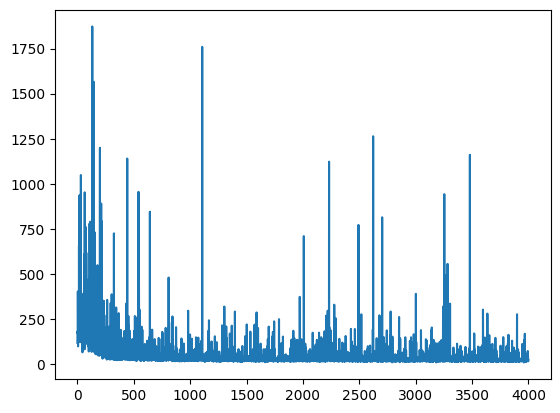

In [ ]:
plt.plot(loss_values)

In [ ]:
log_beta_array = np.linspace(log_beta_min, log_beta_max, 10)

n_test = 10

x_reco_list = []
R_list = []
D_list = []

for log_beta in log_beta_array:
    beta = np.ones((n_test, 1)) * 10 ** log_beta
    x_reco, mean, logvar = beta_vae.apply(params, x[:n_test], beta, key)
    R = rate(mean, logvar,).mean()
    D = distortion(x_reco,x[:n_test], beta).mean()
    R_list.append(R)
    D_list.append(D)
    x_reco = (x_reco* x_std + x_mean).reshape(n_test, n_pixels[0], n_pixels[1]) 
    x_reco_list.append(x_reco)



Text(0.5, 0, 'Distortion')

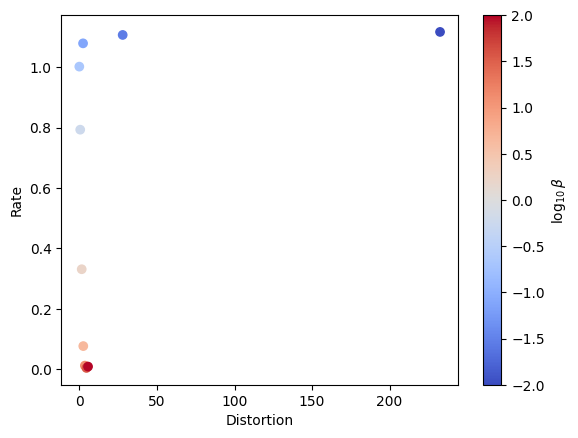

In [ ]:
plt.scatter(D_list, R_list, c=log_beta_array, cmap="coolwarm")
cbar = plt.colorbar(label=r'$\log_{10} \beta$')
cbar.mappable.set_clim(-2, 2)
plt.ylabel('Rate')
plt.xlabel('Distortion')

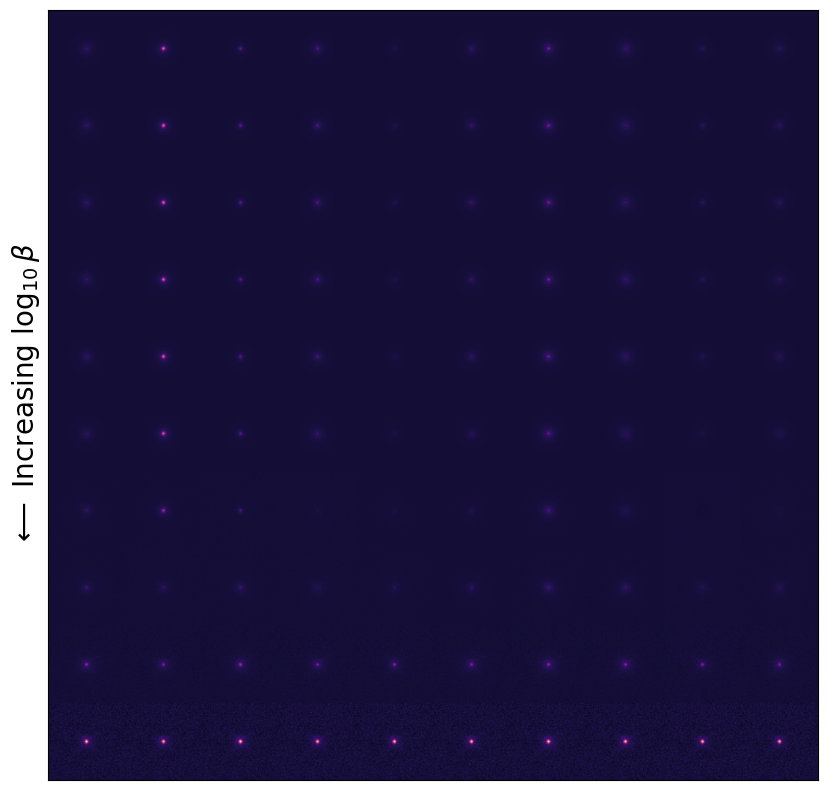

In [ ]:
x_reco_list = np.array(x_reco_list)
x_samples = rearrange(x_reco_list, "n1 n2 h w -> (n1 h) (n2 w)")

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x_samples, cmap='magma')

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel(r'$\longleftarrow~\mathrm{Increasing}~\log_{10} \beta$', rotation=90, fontsize=20);

##  How good is your generative model?

In [ ]:
# 🤔 how good is your model? Train classifier to distinguish real from generated